# Predict sales - sports companies

## Importations

In [1]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

import pickle
import warnings

## Load data 

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [4]:
dataset_train, dataset_test = load_train_test()
dataset_train.isna().sum()

/tmp/ipykernel_462/2459610029.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")


customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              222825
mcp_contact_id             70874
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                224213
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date           66139
max_price                  66139
ticket_sum                     0
average_price              66023
average_purchase_delay     66139
average_price_basket       66139
average_ticket_basket      66139
total_price                  116
purchase_count                 0
first_buying_date          66139
country   

In [18]:
def features_target_split(dataset_train, dataset_test):
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']
            """

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 14)
Shape test :  (96096, 14)


## Prepare preprocessing and Hyperparameters

In [20]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5837086520288036, 1.0: 3.486549107420539}

In [21]:
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [83]:
# preprocess data 
# numeric features - standardize
# categorical features - encode
# encoded features - do nothing

numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                    'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet', 'nb_campaigns', 
                    'nb_campaigns_opened' # , 'gender_male', 'gender_female'
                   ]

numeric_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="mean")),  
    ("scaler", StandardScaler()) 
])

categorical_features = ['opt_in', 'is_email_true']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [80]:
X_train[numeric_features].isna().sum()

nb_tickets             0
nb_purchases           0
total_amount           0
nb_suppliers           0
vente_internet_max     0
purchase_date_min      0
purchase_date_max      0
nb_tickets_internet    0
nb_campaigns           0
nb_campaigns_opened    0
dtype: int64

In [52]:
# Set loss
balanced_scorer = make_scorer(balanced_accuracy_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

In [24]:
def draw_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def draw_roc_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    
    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (14, 8))
    plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC : modèle logistique')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
def draw_features_importance(pipeline, model):
    coefficients = pipeline.named_steps['logreg'].coef_[0]
    feature_names = pipeline.named_steps['logreg'].feature_names_in_
    
    # Tracer l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel('Importance des caractéristiques')
    plt.ylabel('Caractéristiques')
    plt.title('Importance des caractéristiques dans le modèle de régression logistique')
    plt.grid(True)
    plt.show()

def draw_prob_distribution(X_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred_prob, bins=10, range=(0, 1), color='blue', alpha=0.7)
    
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    plt.title('Histogramme des probabilités pour la classe 1')
    plt.xlabel('Probabilité')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [92]:
# Hyperparameter

param_c = np.logspace(-10, 4, 15, base=2)
# param_penalty_type = ['l1', 'l2', 'elasticnet']
param_penalty_type = ['l1']
param_grid = {'logreg__C': param_c,
              'logreg__penalty': param_penalty_type} 

In [26]:
2 ** 10

1024

In [95]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('logreg', LogisticRegression(solver='saga', class_weight = weight_dict,
                                  max_iter=5000))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [40]:
# reduce X_train to reduce the training time

X_train_subsample = X_train.sample(n=10000)
y_train_subsample = y_train.loc[X_train_subsample.index]
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
64466         11.0           4.0         281.4           1.0   
141327         0.0           0.0           0.0           0.0   
59999          2.0           1.0           0.0           1.0   
26882          0.0           0.0           0.0           0.0   
62952         11.0           3.0         325.0           1.0   
...            ...           ...           ...           ...   
141318         0.0           0.0           0.0           0.0   
113838         3.0           2.0          15.0           1.0   
184926         0.0           0.0           0.0           0.0   
14617          1.0           1.0          20.0           1.0   
21685          4.0           1.0          88.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
64466                  1.0         238.330591          30.285040   
141327                 0.0         550.000000         550.000000   
59999                  1.0         350.288926         350.288926   
26882                  0.0         550.000000         550.000000   
62952                  1.0         424.486781         237.282262   
...                    ...                ...                ...   
141318                 0.0         550.000000         550.000000   
113838                 1.0         153.152945          90.277099   
184926                 0.0         550.000000         550.000000   
14617                  0.0         239.258970         239.258970   
21685                  0.0         240.355162         240.355162   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
64466                  11.0           True   False              1   
141327                  0.0           True    True              0   
59999                   2.0           True   False              1   
26882                   0.0           True   False              1   
62952                  11.0           True   False              0   
...                     ...            ...     ...            ...   
141318                  0.0           True    True              0   
113838                  3.0           True    True              0   
184926                  0.0           True    True              0   
14617                   0.0           True    True              0   
21685                   0.0           True    True              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
64466             0           0.0                  0.0  
141327            0          10.0                  0.0  
59999             0           0.0                  0.0  
26882             0           4.0                  1.0  
62952             0           0.0                  0.0  
...             ...           ...                  ...  
141318            0          16.0                  1.0  
113838            1          31.0                 14.0  
184926            1          18.0                  0.0  
14617             1           0.0                  0.0  
21685             1           0.0                  0.0  

[10000 rows x 14 columns]

In [41]:
y_train_subsample

y_has_purchased
64466               0.0
141327              0.0
59999               0.0
26882               0.0
62952               0.0
...                 ...
141318              0.0
113838              0.0
184926              0.0
14617               0.0
21685               0.0

[10000 rows x 1 columns]

In [42]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internetnb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [43]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1', 'l2', 'elasticnet']}

In [46]:
f1_scorer

make_scorer(f1_score, response_method='predict')

In [50]:
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
64466         11.0           4.0         281.4           1.0   
141327         0.0           0.0           0.0           0.0   
59999          2.0           1.0           0.0           1.0   
26882          0.0           0.0           0.0           0.0   
62952         11.0           3.0         325.0           1.0   
...            ...           ...           ...           ...   
141318         0.0           0.0           0.0           0.0   
113838         3.0           2.0          15.0           1.0   
184926         0.0           0.0           0.0           0.0   
14617          1.0           1.0          20.0           1.0   
21685          4.0           1.0          88.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
64466                  1.0         238.330591          30.285040   
141327                 0.0         550.000000         550.000000   
59999                  1.0         350.288926         350.288926   
26882                  0.0         550.000000         550.000000   
62952                  1.0         424.486781         237.282262   
...                    ...                ...                ...   
141318                 0.0         550.000000         550.000000   
113838                 1.0         153.152945          90.277099   
184926                 0.0         550.000000         550.000000   
14617                  0.0         239.258970         239.258970   
21685                  0.0         240.355162         240.355162   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
64466                  11.0           True   False              1   
141327                  0.0           True    True              0   
59999                   2.0           True   False              1   
26882                   0.0           True   False              1   
62952                  11.0           True   False              0   
...                     ...            ...     ...            ...   
141318                  0.0           True    True              0   
113838                  3.0           True    True              0   
184926                  0.0           True    True              0   
14617                   0.0           True    True              0   
21685                   0.0           True    True              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
64466             0           0.0                  0.0  
141327            0          10.0                  0.0  
59999             0           0.0                  0.0  
26882             0           4.0                  1.0  
62952             0           0.0                  0.0  
...             ...           ...                  ...  
141318            0          16.0                  1.0  
113838            1          31.0                 14.0  
184926            1          18.0                  0.0  
14617             1           0.0                  0.0  
21685             1           0.0                  0.0  

[10000 rows x 14 columns]

In [86]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [88]:
# run the pipeline on the subsample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train_subsample, y_train_subsample)

# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification accuracy in train is: {}'.format(logit_grid.best_score_))
# print('Classification accuracy on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification accuracy in train is: 0.47785817197986385


In [89]:
param_c

array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01])

In [96]:
logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [97]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1']}

In [98]:
# run the pipeline on the full sample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train, y_train)

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification accuracy in train is: 0.42160313383818665
Classification accuracy on test is: 0.47078982841737305


In [99]:
# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(logit_grid.best_score_))
print('Classification F1 score on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification F1 score in train is: 0.42160313383818665
Classification F1 score on test is: 0.47078982841737305


In [100]:
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [105]:
logit_grid.__dict__

{'scoring': make_scorer(f1_score, response_method='predict'),
 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['nb_tickets', 'nb_purchases',
                                                    'total_amount',
                                                    'nb_suppliers',
                                                    'vente_internet_max',
                                                    'purchase_date_min',
                                                    'purchase_date_max',
                                                    'nb_tickets_internet',
                                                    'nb_campaigns',
                                                    'nb_campaigns_opened']),
        

In [114]:
# coefficients trouvés pour le modèle optimal
logit_grid.best_estimator_.named_steps["logreg"].coef_

array([[ 1.34302143,  0.        ,  0.02675567,  0.45036527, -0.05004637,
         0.7663532 , -1.35216757,  0.17404712,  0.13679663,  0.10249737,
         0.40815146, -0.6311938 ,  0.11194512, -0.33498749]])

In [125]:
logit_grid.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['nb_tickets', 'nb_purchases', 'total_amount',
                                   'nb_suppliers', 'vente_internet_max',
                                   'purchase_date_min', 'purchase_date_max',
                                   'nb_tickets_internet', 'nb_campaigns',
                                   'nb_campaigns_opened']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['opt_in', 'is_email_true'])]),
 'logreg': LogisticRegression(C=0.03125,
                    class_weight={0.0: 0.5837086520288036,
                                  1.0: 3.4865491

In [116]:
logit_grid.best_estimator_.named_steps["logreg"].intercept_

array([-0.22304234])

In [115]:
# c'est la 2ème variable nb_purchases qui a été supprimée par le LASSO
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [122]:
# best param : alpha = 32
1/logit_grid.best_params_["logreg__C"]

32.0

In [127]:
# print results for the best model

y_pred = logit_grid.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.7589597902097902
F1 Score: 0.47078982841737305
Recall Score: 0.7525931336742148


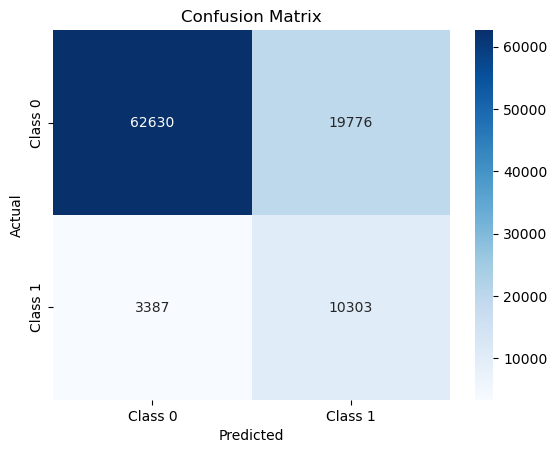

In [128]:
# confusion matrix 

draw_confusion_matrix(y_test, y_pred)

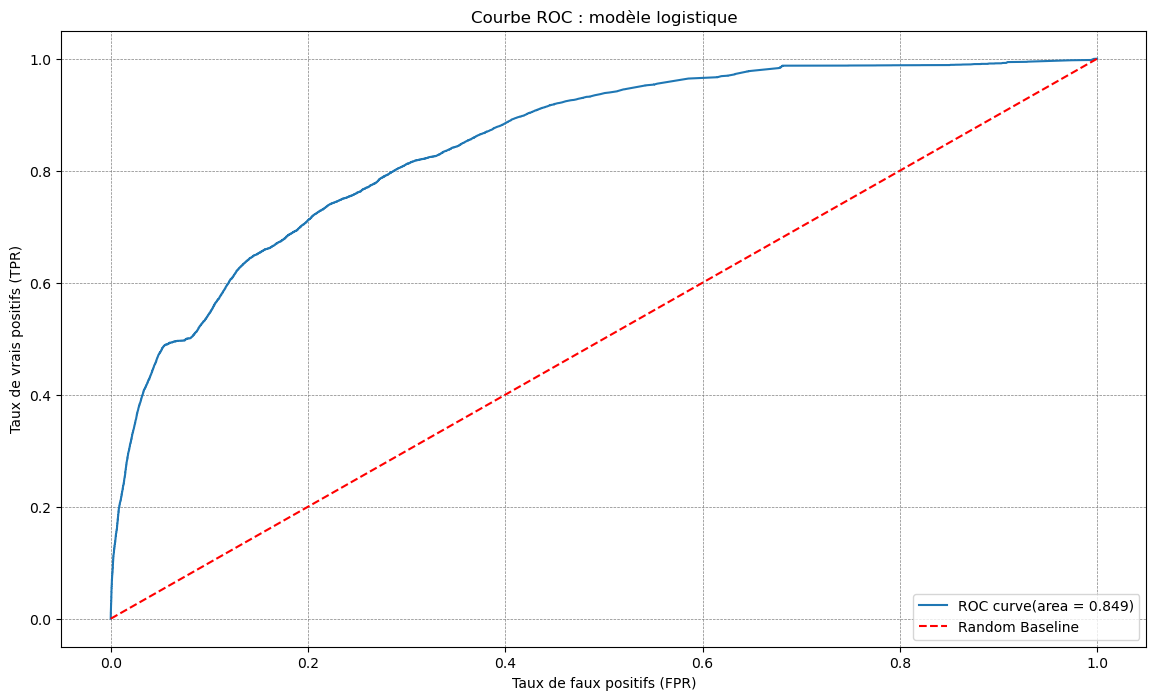

In [138]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = logit_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : modèle logistique')
plt.legend(loc="lower right")
plt.show()